## Конфигурация 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

import pymorphy2
import nltk
from tqdm import tqdm

import sys
def add_sys_path(p):
    if p not in sys.path:
        sys.path.append(p)
add_sys_path(os.path.dirname(os.getcwd()))

from test_problem import util

In [2]:
INPUT_ROOT = os.path.join('..','INPUT')

## Загрузка, предобработка отзывов

In [3]:
d1 = pd.read_csv(os.path.join( INPUT_ROOT, 'dataset1.csv'), index_col=0)
print(d1.shape)
d1.head(3)

(270941, 15)


,PRODUCT,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT
0,30024724,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,Что особенно ценно - при профилактике принтера...,23.10.16 22:26:00,5.0,"хорошая скорость печати, двусторонняя печать, ...","Рядом ""на стол"" не поставишь, место много зани...",1.0,2.0,0.0
1,30024724,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,Он у нас три месяца в офисе стоит уже - большо...,17.04.16 11:17:42,5.0,NaN,NaN,NaN,0.0,2.0
2,30024725,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,"Просто небо и земля с тем принтером, который у...",15.04.16 20:22:47,4.0,NaN,NaN,NaN,0.0,1.0


Запускаю лемматизацию всех отзывов. 

In [5]:
l = []
for text in tqdm(d1.TEXT):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['TEXT_prepared'] = l

100%|█████████████████████████████████████████████████████████████████████████| 270941/270941 [08:57<00:00, 504.36it/s]


In [151]:
l = []
for text in tqdm(d1.SUBJECT.fillna('')):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['SUBJECT_prepared'] = l

100%|████████████████████████████████████████████████████████████████████████| 270941/270941 [00:49<00:00, 5467.26it/s]


In [152]:
l = []
for text in tqdm(d1.BENEFITS.fillna('')):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['BENEFITS_prepared'] = l

100%|████████████████████████████████████████████████████████████████████████| 270941/270941 [00:36<00:00, 7499.66it/s]


In [153]:
l = []
for text in tqdm(d1.DRAWBACKS.fillna('')):
    l.append(' '.join(util.lemmatize(util.tokenize(util.replace_smiles(text)))))
d1['DRAWBACKS_prepared'] = l

100%|████████████████████████████████████████████████████████████████████████| 270941/270941 [00:29<00:00, 9248.25it/s]


In [212]:
prod2categ = d1.CATEGORY_ID.groupby(d1.PRODUCT).aggregate(lambda x:x.value_counts().index[0])

In [210]:
categ2name = d1.CATEGORY_NAME.groupby(d1.CATEGORY_ID).aggregate(lambda x:x.value_counts().index[0])

In [10]:
d1[['SUBJECT','TEXT', 'BENEFITS','DRAWBACKS', 'RECOMMENDED', 'RATING', 'TEXT_prepared']].sample(1).squeeze().to_dict()

{'BENEFITS': nan,
 'DRAWBACKS': nan,
 'RATING': 5.0,
 'RECOMMENDED': nan,
 'SUBJECT': 'Все нравится, диск качественный',
 'TEXT': 'По мне так этот аппарат стоит своих денег, у него не только высокие скорости передачи и чтения файлов за счет 3.0 интерфейса, но еще и полная защита от всех возможных проблем с файлами, воды не боится, влаги тоже, как и ударов, тут вообще один из слоев упругий, падения амортизируются им. Памяти куча, хранилище из него отличное',
 'TEXT_prepared': 'по я так этот аппарат стоить свой деньга , у он не только высокий скорость передача и чтение файл за счёт 3.0 интерфейс , но ещё и полный защита от весь возможный проблема с файл , вода не бояться , влага тоже , как и удар , тут вообще один из слой упругий , падение амортизироваться имя . память куча , хранилище из он отличный'}

In [17]:
ps = '\n***\n'
d1['total_text'] = (d1['SUBJECT'].fillna('') + ps + d1['TEXT'].fillna('') + ps + d1['BENEFITS'].fillna('') 
                    + ps + d1['DRAWBACKS'].fillna(''))

In [154]:
d1['total_text_prepared'] = (d1['SUBJECT_prepared'].fillna('') + ps + d1['TEXT_prepared'].fillna('') + ps 
                             + d1['BENEFITS_prepared'].fillna('') + ps + d1['DRAWBACKS_prepared'].fillna(''))

In [181]:
print(d1['total_text_prepared'].sample(1).values[0])

вопрос ?
***
народ , а он у я почему-то сам перезагружаться , только что купить , сказать , пожалуйста , так и должный быть , или это глюк в он какой-нибудь ? ? ? ?
***

***



In [182]:
rs = '\n*******\n'
text_by_product = d1[['total_text', 'total_text_prepared']].groupby(d1['PRODUCT']).aggregate(lambda x : rs.join(x))
text_by_product.shape

(36475, 2)

In [190]:
print(text_by_product.sample(1).values[0])

[ 'BEKO DIS 5831\n***\nПользуюсь 4 месяца. Покупали к рождению ребенка, чтобы облегчить себе жизнь. Да, современная бытовая техника позволяет вздохнуть с облегчением. Итак:\n1) обычно пользуемся программой №7 (2часа), т.к. с ней очень хорошо промывается все,в том числе и бутылки для детского питания. Реже используем программу №5 (58 мин) - когда нет особо грязной или засохшей посуды.\n2) Советую, чтоб потом не жаловаться на пятна, правильно настроить дозатор кондиционера.\n3) После мойки советую машину открыть (или приоткрыть - если не собираетесь доставать посуду) минут на 5-10, посуда горячая, и так она вся обсохнет.\n4) При мойке ночью  шумновато. Хотя днем нормально.\n    Как она мое - это просто сказка. Такой наша посуда была только в день покупки. Руками так никогда не отмыть.Не машина - праздник.\n***\n\n***\n\n*******\nРекомендую!\n***\nОтличная машинка. Даже не ожидала, что так отлично будет отмывать посуду. Стаканы, тарелки, ложки, банки, сковородки - идеально чисто даже без 

In [191]:
text_by_product.columns

Index(['total_text', 'total_text_prepared'], dtype='object')

In [251]:
def add_bigrams_to_text(text):
    return ' '.join(util.add_bigrams(util.tokenize(text)))

In [256]:
text_by_product.columns

Index(['total_text', 'total_text_prepared'], dtype='object')

In [258]:
text_by_product['text_bigram'] = text_by_product['total_text'].apply(add_bigrams_to_text)
text_by_product['prep_bigram'] = text_by_product['total_text_prepared'].apply(add_bigrams_to_text)

## Гипотеза 1: tf-idf 

Как отрабатывает на товаре vs все? Плохо

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
vec = TfidfVectorizer(min_df = 3, max_df = 0.95)

In [192]:
vec.fit(text_by_product['total_text_prepared'])
print(len(vec.vocabulary_))

50098


In [ ]:
categ_sample

In [265]:
categ2tfidf = dict()
for categ in set(prod2categ.values):
    categ_sample = text_by_product[prod2categ[text_by_product.index]==categ]
    try:
        categ2tfidf[categ] = TfidfVectorizer(min_df = 3, max_df = 0.95).fit(categ_sample['prep_bigram'])
    except ValueError:
        print(categ2name[categ], ' is to small', categ_sample.shape)

FAXES                                       is to small (2, 4)
IONIZER                                     is to small (2, 4)
DEHUMIDIFIER                                is to small (1, 4)
OLED-TV 40\" - 55\"                         is to small (1, 4)
ACCESSORIES FOR NINTENDO WII                is to small (1, 4)
COMPACT PHOTOPRINTERS                       is to small (1, 4)
OTHERS TELECOMMUNICATION PRODUCTS           is to small (1, 4)
AUDIO/CD RECORDED                           is to small (3, 4)
XEROX                                       is to small (3, 4)
OTHERS TELECOMMUNICATIONS                   is to small (2, 4)
PHONE ADDITIONAL DEVICES                    is to small (3, 4)
ELECTRONIC DICTIONARIES                     is to small (1, 4)
AUDIOBOOKS                                  is to small (3, 4)
3D DIGITAL CAMERAS                          is to small (1, 4)
NEW PLANNAME PHOTO-AUTO 6                   is to small (1, 4)
PHOTO PRINTING                              is to small

In [203]:
sample = text_by_product.sample(1)
tmp = vec.transform(sample['total_text_prepared']).todense()
tmp[tmp<0.1] = 0
print(vec.inverse_transform(tmp)[0])
print(sample['total_text'].values[0])

['combo' 'keyboard' 'logitech' 'russian' 'wireless' 'батарейка' 'клава'
 'клавиатура' 'кнопка' 'колесико' 'комплект' 'мышь' 'не' 'передатчик'
 'планшет' 'язык']

***
с расстояния в три метра клава ну просто отказывается реагировать на мои нажатия на кнопки. сейчас пишу с расстояния в 1 метр - прием удовлетворительный!!!
скорее всего, завтра пойду менятьь на что-то постабильней!
***
мышь,.  вврродее бы,. ничего
***
клава -  отвратительна!!!
*******
Комплект клавиатура+мышь Logitech Wireless Combo MK220 
***
очень шумная клавиатура.
сливает по этому параметру конкуренту Genius SlimStar 8000ME НА ПОРЯДКИ, у того комплекта реально по сравнению с логитеком бесшумная клавиатура
***

***

*******
Смена языков
***
Языки при работе с андроидом меняются нажатием клавиш shift+пробел.
***

***

*******

***
покупайте у кого денег мало,  и надоели провода.
***
ДЕШЕВАЯ БЕСПРОВОДНАЯ КЛАВИАТУРА.Батарейки  НАДОЛГО ХВАТАЕТ
***
нет
*******

***
Купил 09.12.2016 для самсунг смарт тв дак он её вообще нехоч

Как отрабатывает на товаре vs категория? Чуть лучше

0.14284264945632416

In [305]:
sample = text_by_product.sample(1)

categ = prod2categ[sample.index[0]]
print(categ, categ2name[categ])
# все тексты об этой категории
if categ in categ2tfidf:
    vec0 = categ2tfidf[categ]
    #categ_sample = text_by_product[prod2categ[text_by_product.index]==categ]
    #vec.fit(categ_sample['total_text_prepared'].apply(add_bigrams_to_text))
    tmp = vec0.transform(sample['total_text_prepared'].apply(add_bigrams_to_text)).todense()
    threshold = sorted(np.array(tmp)[0],reverse=True)[5]
    tmp[tmp<threshold] = 0
    print(vec0.inverse_transform(tmp)[0])
    print(sample['total_text'].values[0])
else:
    print('too small categ')

4130401 HAIR CARE                                 
['волос' 'для_завивка' 'если_использовать' 'утюжок' 'утюжок_на' 'шнур_в']

***
У меня волосы пушистые и тонкие, укладывать их трудно. А этот утюжок на удивление легко справился с беспорядком у меня на голове. Понравилось, что корпус имеет скругления, удобно, если используешь утюжок для завивки. 
***
Удобный, быстро нагревается, можно использовать и для выпрямления, и для завивки.
***
Туговаты кнопки для переключения температуры
*******

***
Хотелось себе именно качественный выпрямитель, который нормально работает и при этом не испортит мои волосы. Вьющиеся волосы не мое, поэтому пользуюсь им часто. И всегда прическа сохраняется долго. Нравится, что им нельзя сжечь волосы. Кстати, он еще и завивает, поэтому даю иногда сестре, она наоборот очень хочет вьющиеся волосы.
***
Отлично и надолго выпрямляет, не жжет кончики, турмалиновое покрытие, наличие 8 режимов
***
Не нахожу
*******

***
Вчера опробовала этот утюжок на своих волосах. Разгла

# Гипотеза 2: любимые комменты

In [307]:
d1[['LIKES_COUNT','DISLIKES_COUNT']].describe()

,LIKES_COUNT,DISLIKES_COUNT
count,261987.000000,261987.000000
mean,12.077347,7.512342
std,43.402505,31.594347
min,0.000000,0.000000
25%,1.000000,0.000000
50%,5.000000,2.000000
75%,13.000000,7.000000
max,11048.000000,10207.000000


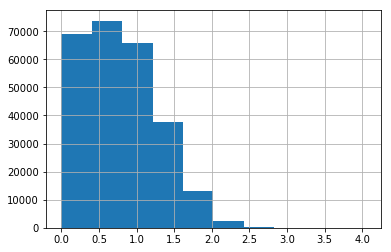

In [309]:
np.log10(1+d1.LIKES_COUNT).hist()

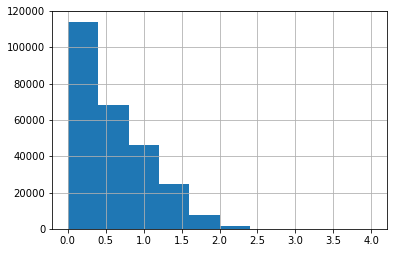

In [310]:
np.log10(1+d1.DISLIKES_COUNT).hist()

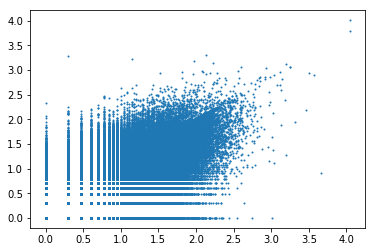

In [312]:
plt.scatter(np.log10(1+d1.LIKES_COUNT), np.log10(1+d1.DISLIKES_COUNT), s = 1)

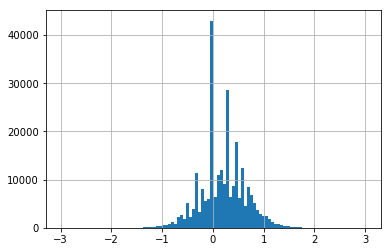

In [314]:
likeness = np.log10(1+d1.LIKES_COUNT)- np.log10(1+d1.DISLIKES_COUNT)
likeness.hist(bins=100)

пытаемся предсказать, насколько рейтинг понравится, по 

In [324]:
y = likeness.fillna(0)
x = d1['total_text_prepared']
print(x.shape, y.shape)

(270941,) (270941,)


In [320]:
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit, KFold
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score

In [330]:
pipe_tf = TfidfVectorizer(min_df=3).fit(x)
pipe_x = pipe_tf.transform(x)
print(pipe_x.shape)

(270941, 54029)


In [333]:
#pipe = make_pipeline(TfidfVectorizer(min_df=3), Ridge(1))
cross_val_score(Ridge(10), pipe_x, y, cv= KFold(2, shuffle=True, random_state=1), n_jobs=-1)

array([ 0.0876423 ,  0.08392991])

In [ ]:
reg = Ridge(10).fit()